<a href="https://colab.research.google.com/github/seyyadzishanali-CUI/Multilingual_Event_Aware_Content_Prioritization_Code/blob/main/Sample_Executed_Code_For_Guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy
import csv
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_pickle('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/Final-pre-processed.pkl')

In [ ]:
# Specify the number of repetitions for each class
repetitions_per_class = 10
df_new = pd.DataFrame()
# Group the DataFrame by the 'class' column
grouped_df = df.groupby('Classification')
# Iterate over each group
for _, group in grouped_df:
    # Sample 1000 rows from each group and concatenate them to df_repeated
    df_new = pd.concat([df_new, group.sample(n=repetitions_per_class, replace=True)])
# Reset the index of the resulting DataFrame
df_new = df_new.reset_index(drop=True)

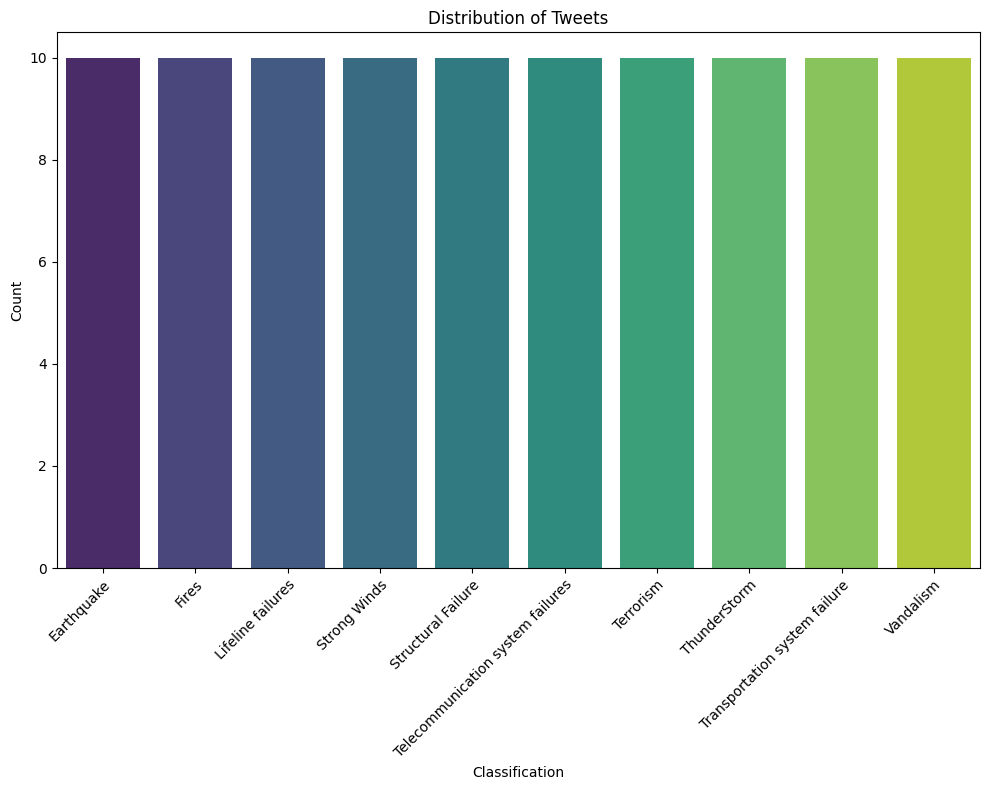

In [ ]:
# Assuming 'arr1' is your DataFrame with 'stemmed' and 'Classification' columns
# Replace this with your actual DataFrame and column names

plt.figure(figsize=(10, 8))
# Count the occurrences of each class
class_counts = df_new['Classification'].value_counts()
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
# Increase the space between x-axis labels
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Distribution of Tweets')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
df_new.to_csv('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/24-12-2023/Multilingual_Tweets.csv')

In [ ]:
#df_new.dropna(subset=['stemmed'], inplace=True)
df_new = df_new[df_new['stemmed'].apply(lambda x: len(x) > 0)]
df_new['preprocessed'] = df_new['stemmed'].apply(lambda x: ' '.join(x))
df_new.shape

<ipython-input-16-a57150ddcabc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['preprocessed'] = df_new['stemmed'].apply(lambda x: ' '.join(x))


(90, 15)

In [ ]:
#Bert Tokenizer and mBERt Embedding for Multilingual data
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW
import torch.nn as nn
from sklearn.cluster import KMeans
import numpy as np
import nltk
nltk.download('stopwords')

# mBERT Tokenizer and Model (mBERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Custom Dataset class for DataLoader
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], return_tensors='pt', truncation=True, padding=True)
        input_ids = encoding['input_ids'].squeeze()
        return input_ids

# Encode tweets using mBERT
encoded_tweets = []
embeddings = []
for tweet in df_new['preprocessed']:
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    encoded_tweets.append(embeddings)

encoded_tweets = np.vstack(encoded_tweets)
# create a Pandas DataFrame from the dictionary
df2 = pd.DataFrame(encoded_tweets)

# write the DataFrame to a CSV file
df2.to_csv('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/24-12-2023/mBERT_Tokenized_EMBEDDED_Data(100).csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


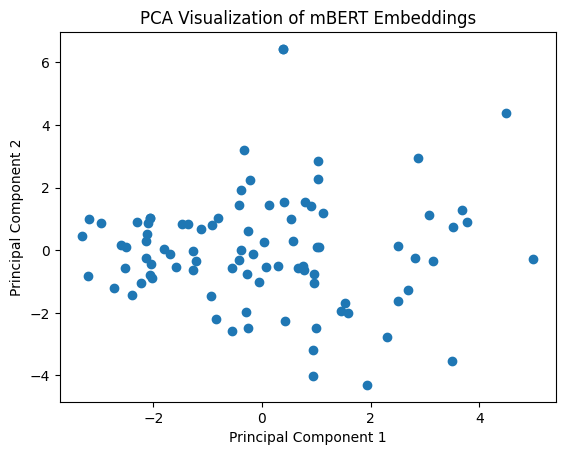

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_tweets)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.title('PCA Visualization of mBERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Autoencoder Configuration
input_size = encoded_tweets.shape[1]
encoding_dim = 13  # You can adjust this based on the desired encoding dimension
clusters=''
# Train Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder(input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

# Convert encoded_tweets to PyTorch tensor
encoded_tweets_tensor = torch.tensor(encoded_tweets, dtype=torch.float32)

# DataLoader for autoencoder training
autoencoder_dataloader = DataLoader(encoded_tweets_tensor, batch_size=100, shuffle=True)

# Training loop for autoencoder
num_epochs = 15
for epoch in range(num_epochs):
    for batch in autoencoder_dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

# Apply K-Means clustering on autoencoder encoded representations
encoded_tweets_tensor = torch.tensor(encoded_tweets, dtype=torch.float32)
encoded_reps = autoencoder.encoder(encoded_tweets_tensor).detach().numpy()

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(encoded_reps)

# Add cluster information to the DataFrame
df_new['mBERT_Autoencoder_cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


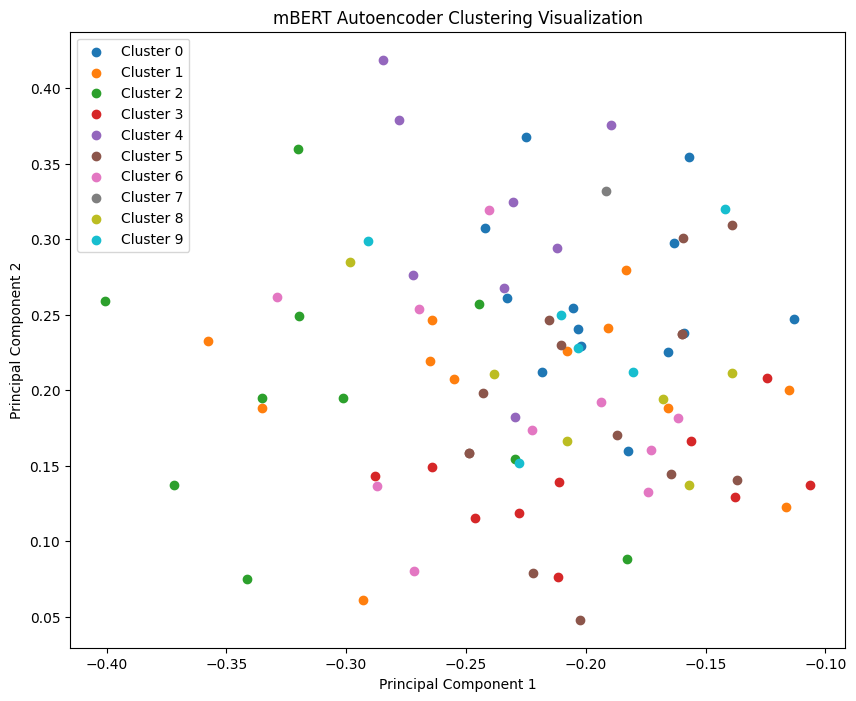

In [ ]:
# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 8))
for cluster_label in range(10):  # Assuming 10 clusters
    cluster_data = encoded_reps[clusters == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

plt.title('mBERT Autoencoder Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


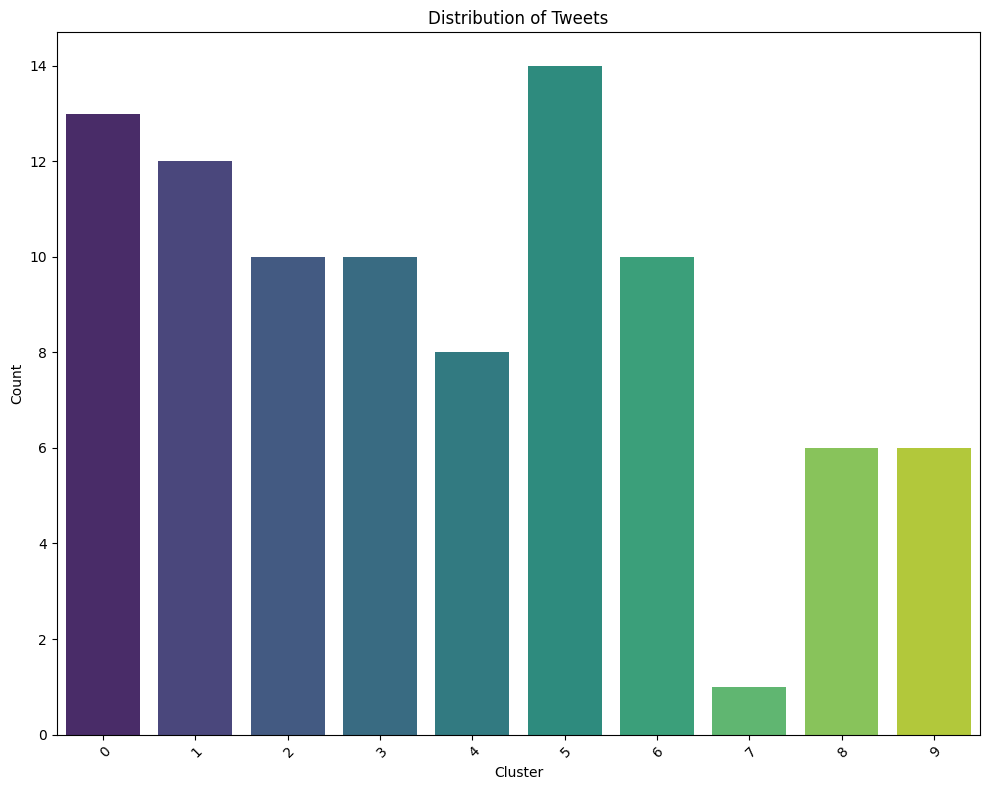

In [ ]:
# Assuming 'arr1' is your DataFrame with 'stemmed' and 'Classification' columns
# Replace this with your actual DataFrame and column names

plt.figure(figsize=(10, 8))
# Count the occurrences of each class
class_counts = df_new['mBERT_Autoencoder_cluster'].value_counts()
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
# Increase the space between x-axis labels
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Tweets')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

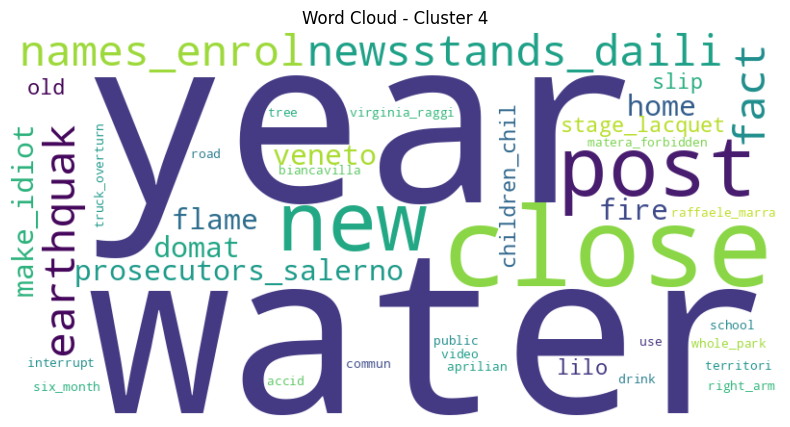

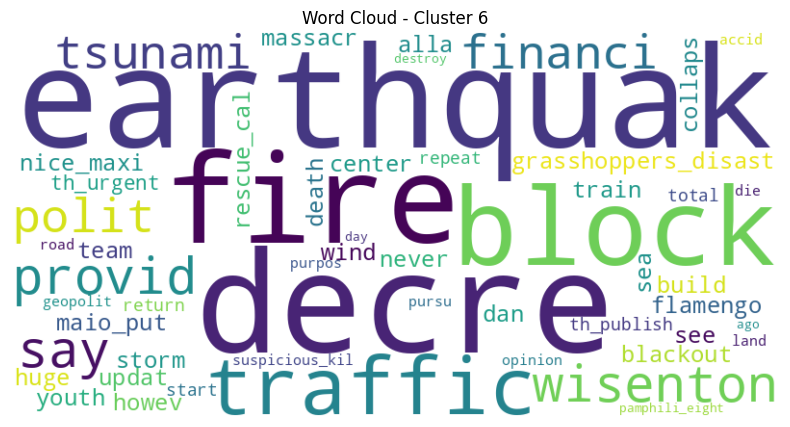

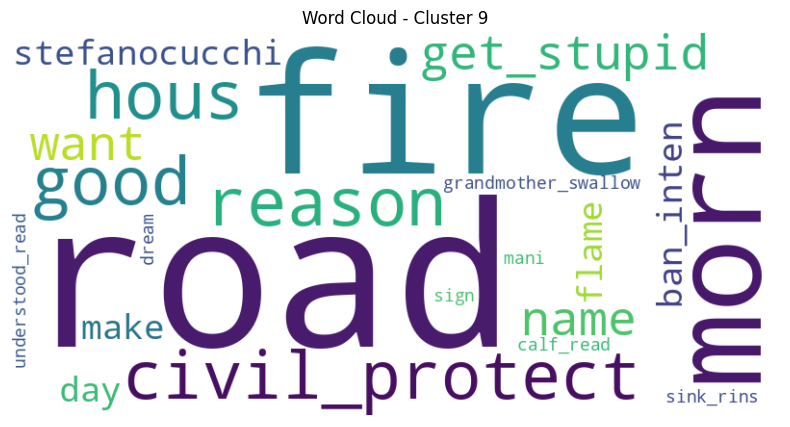

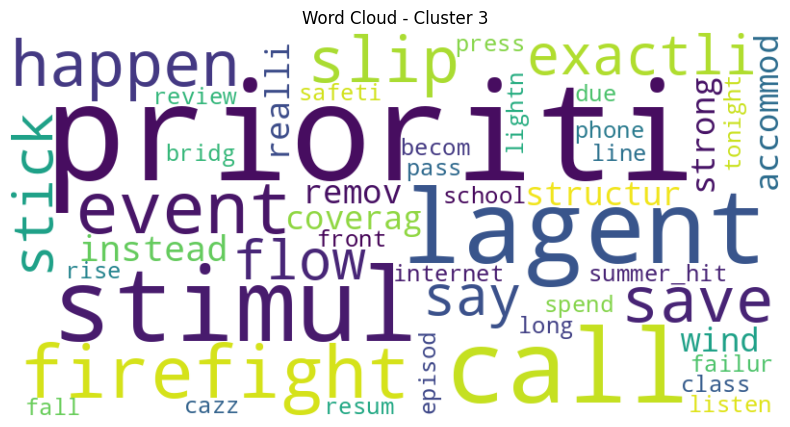

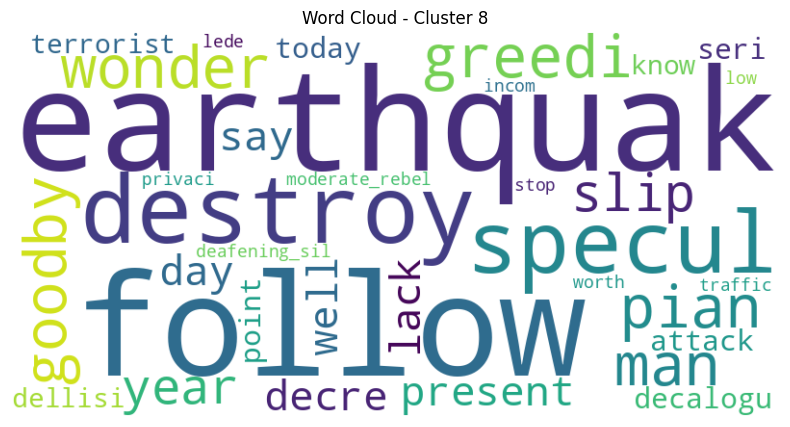

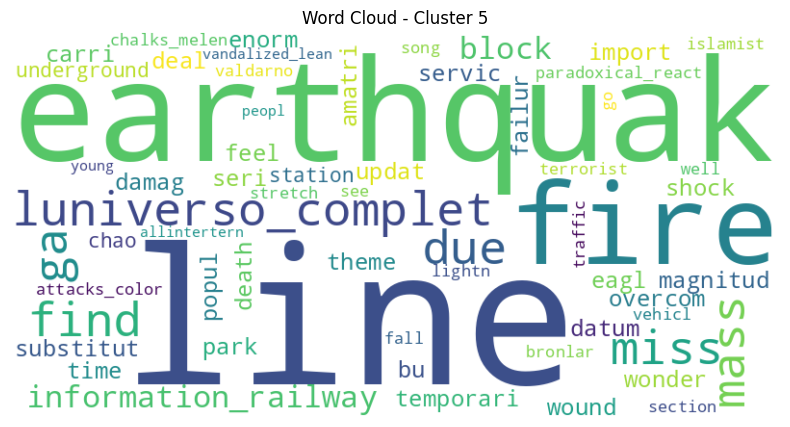

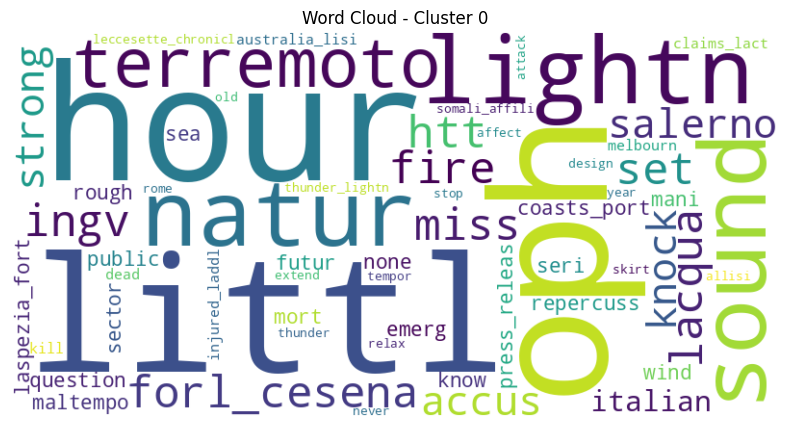

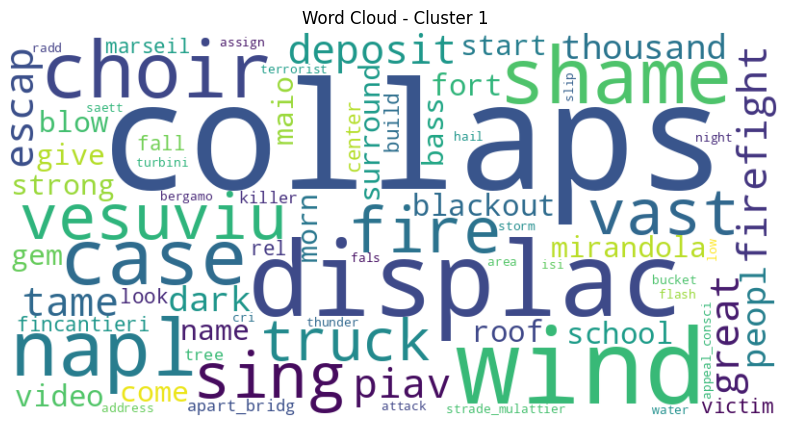

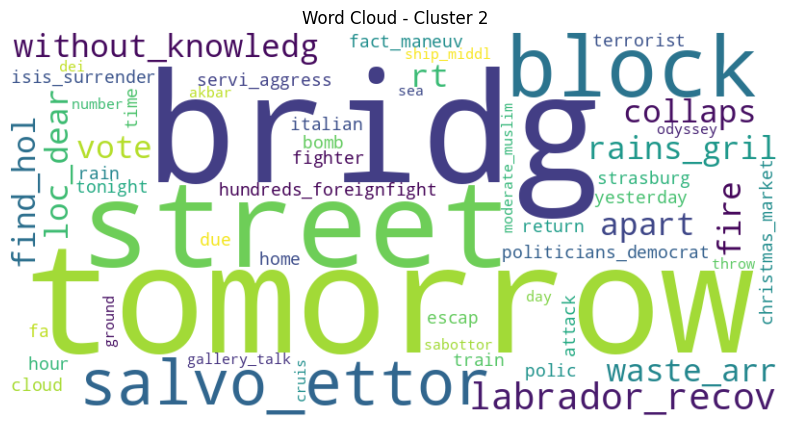

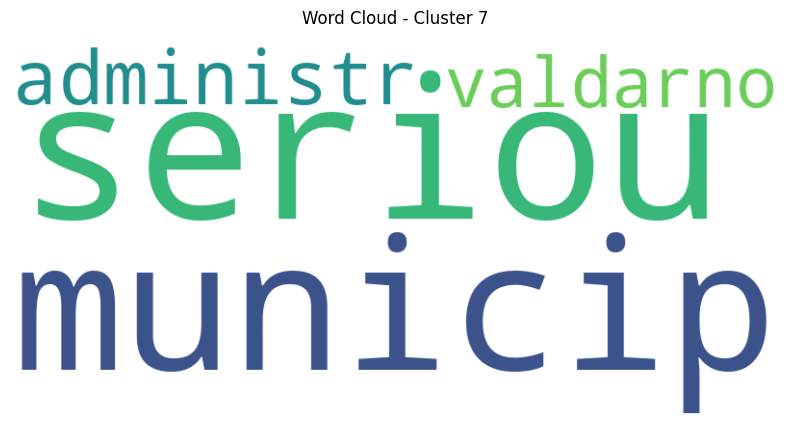

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a 'cluster' column and a 'text' column
# df = ...

# Generate WordClouds for each cluster
for cluster_id in df_new['mBERT_Autoencoder_cluster'].unique():
    # Extract text for the current cluster
    cluster_text = ' '.join(df_new[df_new['mBERT_Autoencoder_cluster'] == cluster_id]['preprocessed'])

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Cluster {cluster_id}')
    plt.axis('off')
    plt.show()

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
#To ensure that embeddings not contain negative values
constant_value = abs(np.min(encoded_tweets)) + 1
encoded_tweets += constant_value
# Extract topics using LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda.fit_transform(encoded_tweets)

# Normalize LDA topic distributions
lda_topics_normalized = normalize(lda_topics, norm='l1')

# Combine mBERT embeddings with LDA topics
combined_features = np.hstack([encoded_tweets, lda_topics_normalized])

# Apply K-Means clustering on combined features
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(combined_features)

# Add cluster information to the DataFrame
df_new['mBERT_LDA_cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


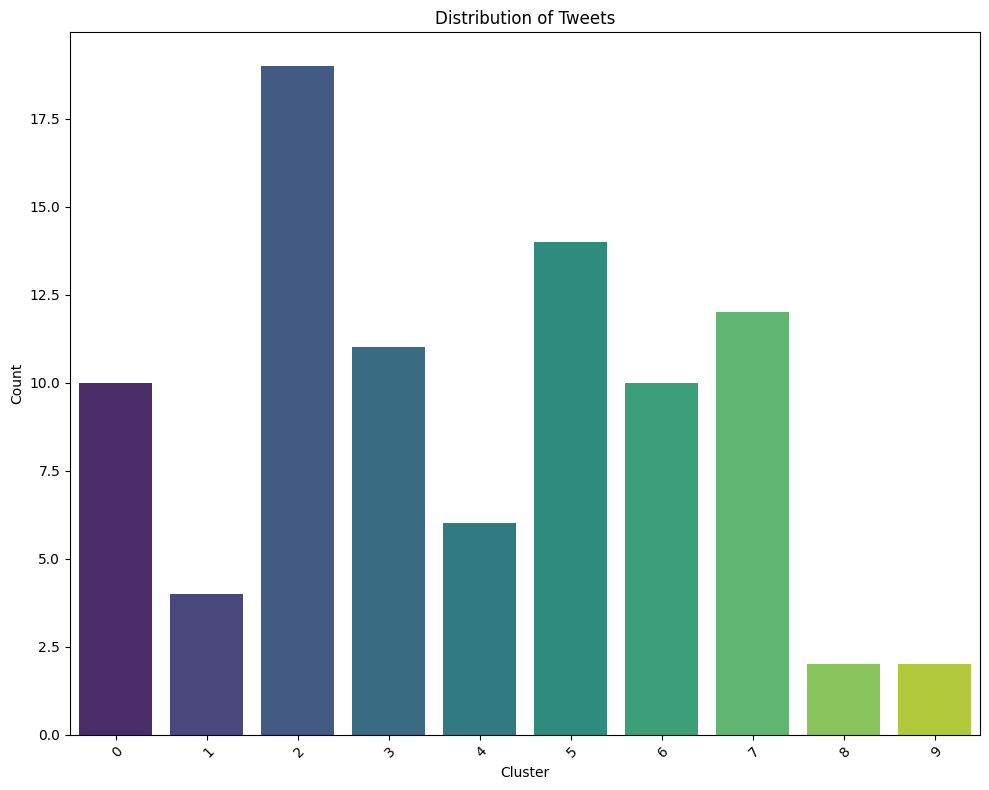

In [ ]:
plt.figure(figsize=(10, 8))
# Count the occurrences of each class
class_counts = df_new['mBERT_LDA_cluster'].value_counts()
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
# Increase the space between x-axis labels
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Tweets')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

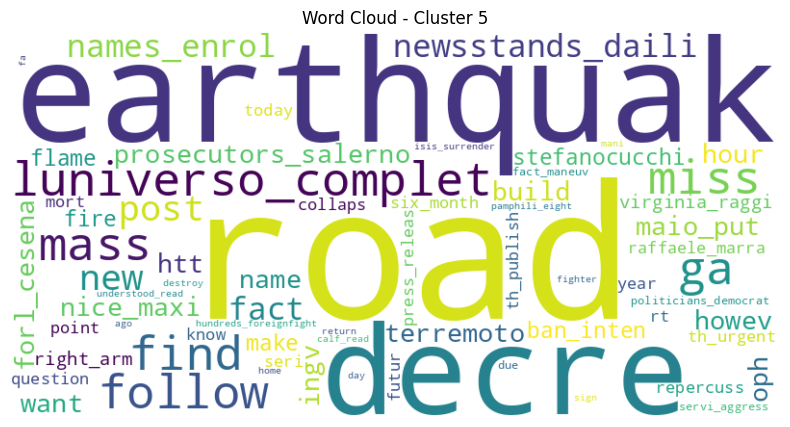

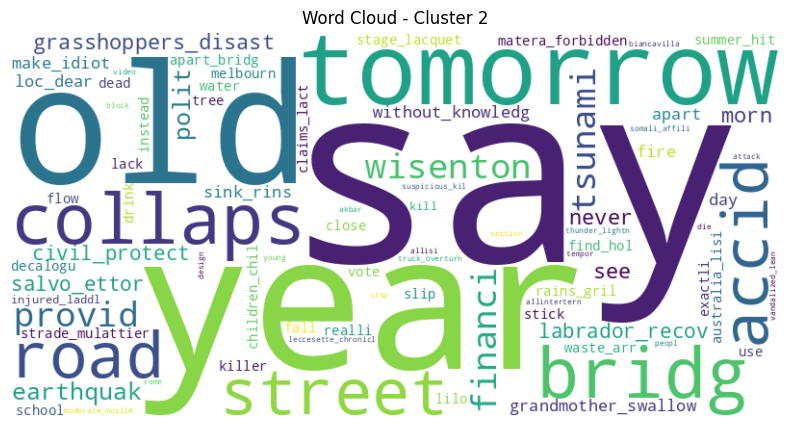

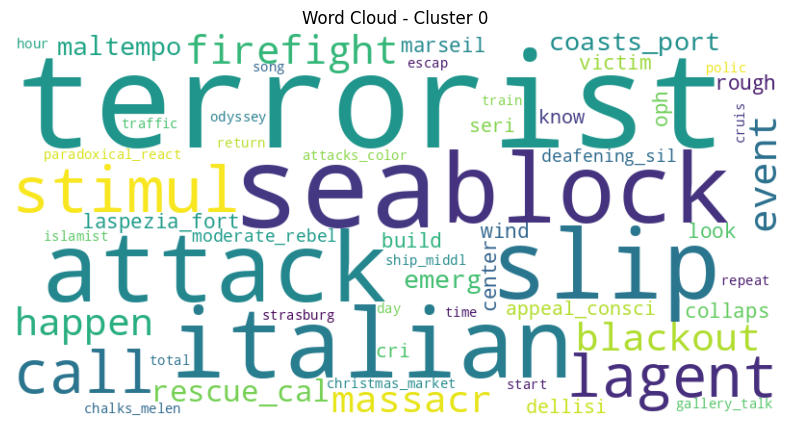

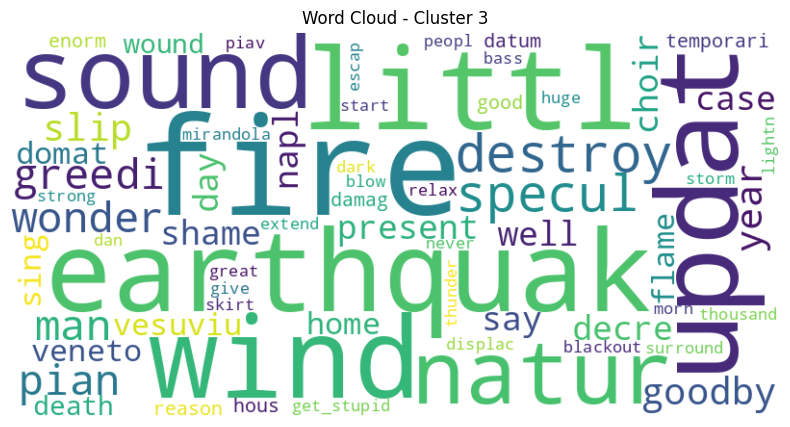

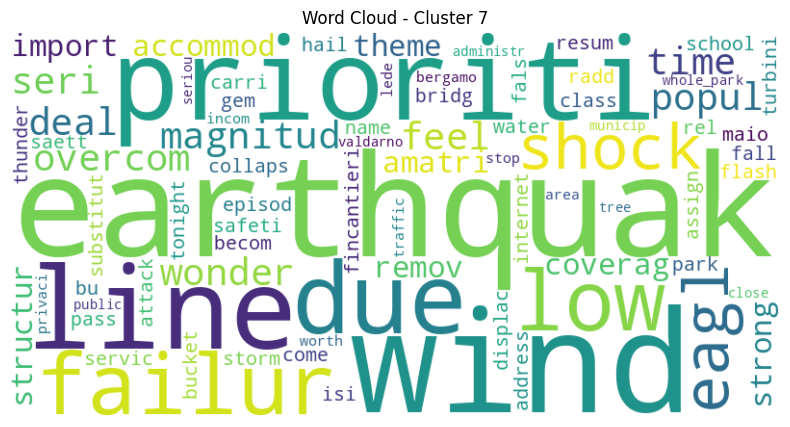

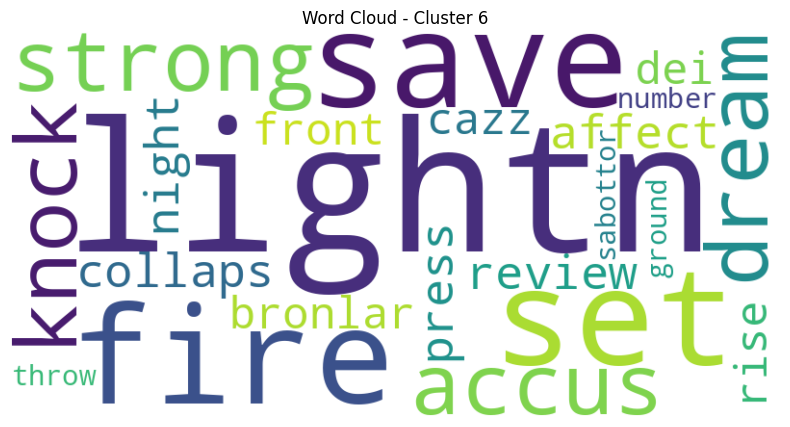

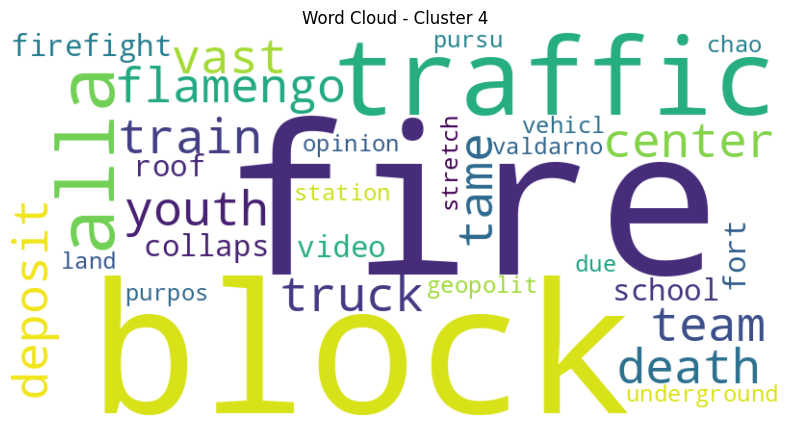

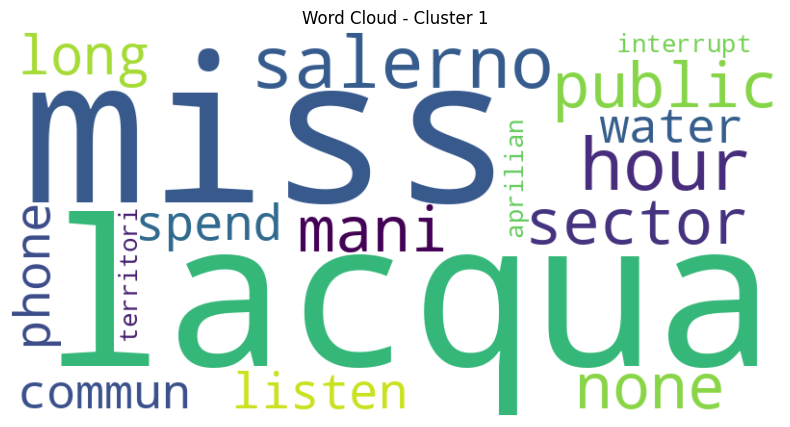

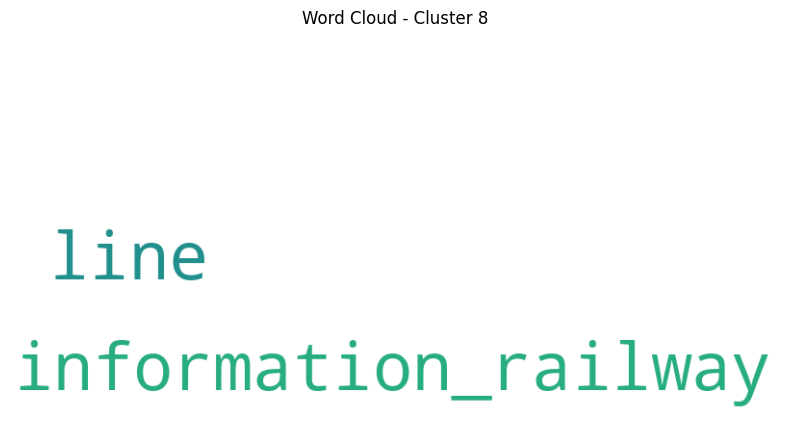

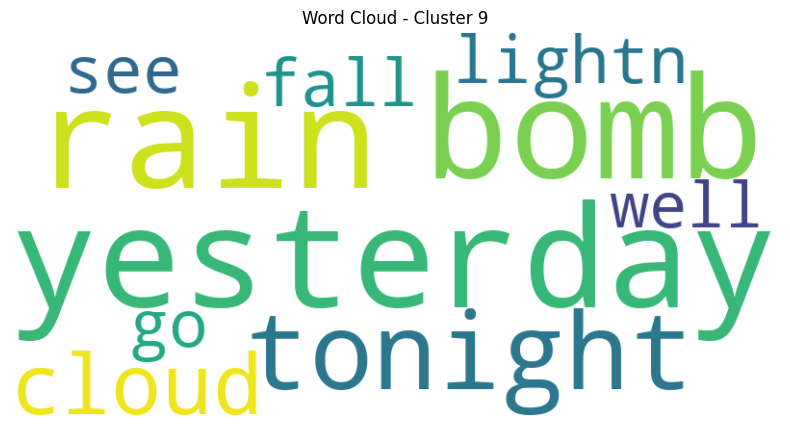

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a 'cluster' column and a 'text' column
# df = ...

# Generate WordClouds for each cluster
for cluster_id in df_new['mBERT_LDA_cluster'].unique():
    # Extract text for the current cluster
    cluster_text = ' '.join(df_new[df_new['mBERT_LDA_cluster'] == cluster_id]['preprocessed'])

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Cluster {cluster_id}')
    plt.axis('off')
    plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim.models import CoherenceModel
import nltk

# Download NLTK stopwords
nltk.download('stopwords')

# Text preprocessing: remove special characters, lowercase, and remove stopwords
stop_words = set(stopwords.words('english'))
df_new['processed_text'] = df_new['preprocessed'].apply(lambda x: ' '.join([word.lower() for word in x if word.lower() not in stop_words]))

# Create a dictionary and corpus for Gensim LdaModel
corpus = [text.split() for text in df_new['processed_text']]
dictionary = corpora.Dictionary(corpus)
corpus_gensim = [dictionary.doc2bow(text) for text in corpus]

# Apply Gensim LdaModel for topic modeling
num_topics = 10  # You can adjust this based on the expected number of topics
lda_gensim = LdaModel(corpus=corpus_gensim, id2word=dictionary, num_topics=num_topics, random_state=42)

# Get topics for each tweet
df_new['LDA_topics'] = df_new['processed_text'].apply(lambda text: max(lda_gensim.get_document_topics(dictionary.doc2bow(text.split())), key=lambda x: x[1])[0])
# Evaluate Perplexity (if needed)
# Note: Gensim's LdaModel has a perplexity method
perplexity = lda_gensim.log_perplexity(corpus_gensim)
print(f"Perplexity: {perplexity}")

# Calculate Coherence Score
coherence_model = CoherenceModel(model=lda_gensim, texts=corpus, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Perplexity: -2.923731308399862
Coherence Score: 0.3620166805543922


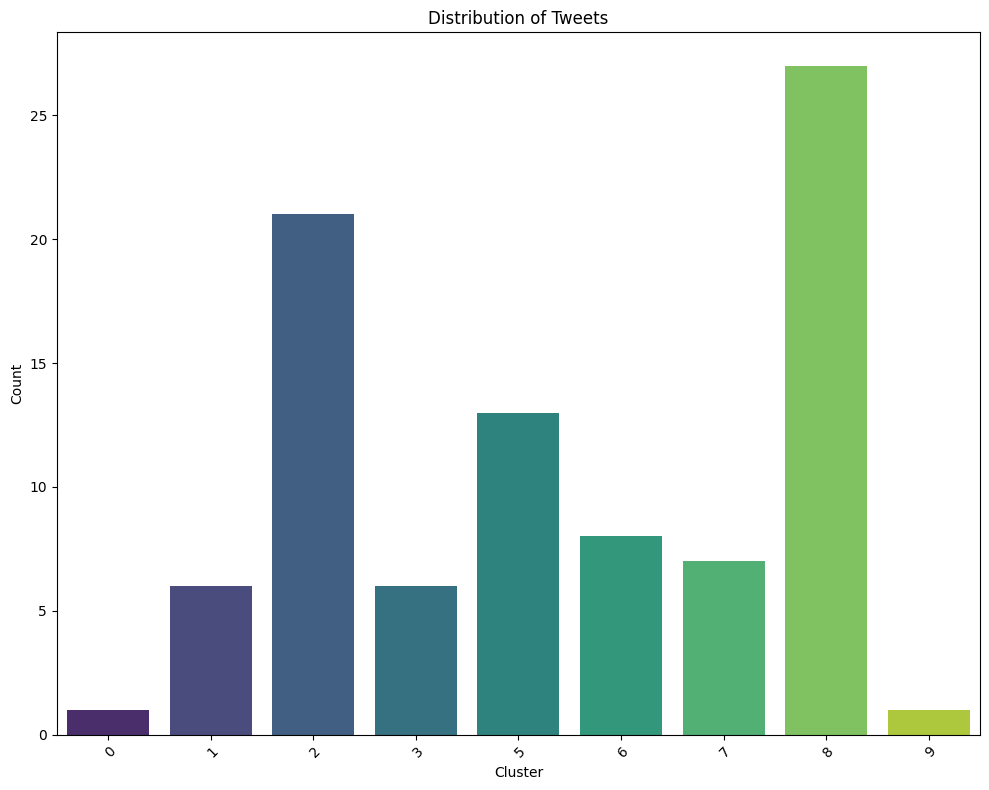

In [ ]:
# Assuming 'arr1' is your DataFrame with 'stemmed' and 'Classification' columns
# Replace this with your actual DataFrame and column names

plt.figure(figsize=(10, 8))
# Count the occurrences of each class
class_counts = df_new['LDA_topics'].value_counts()
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
# Increase the space between x-axis labels
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Tweets')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

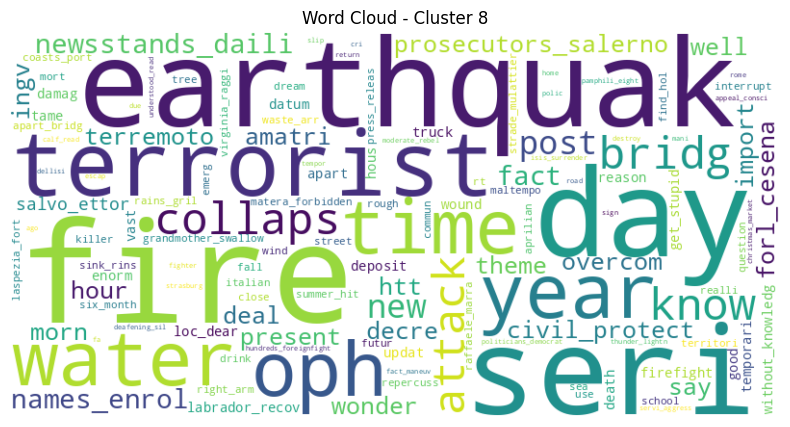

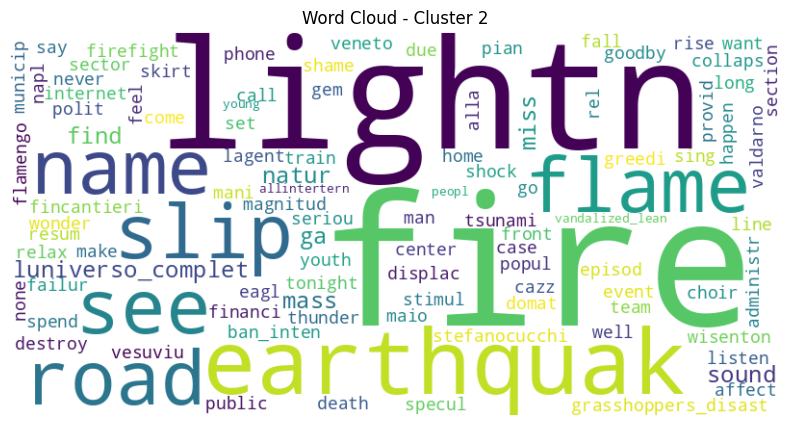

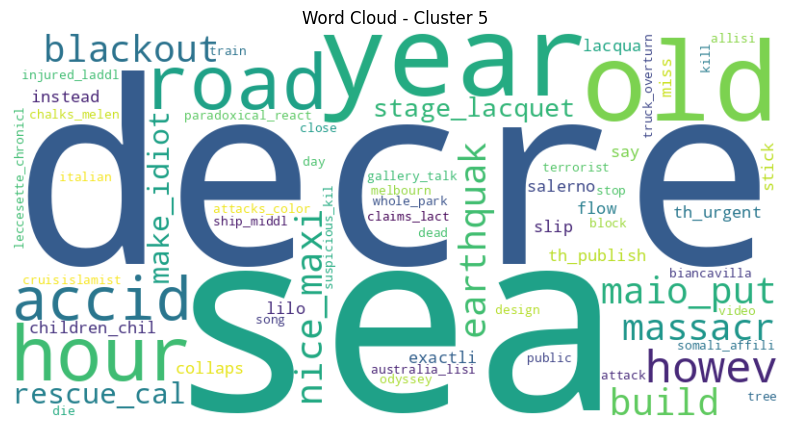

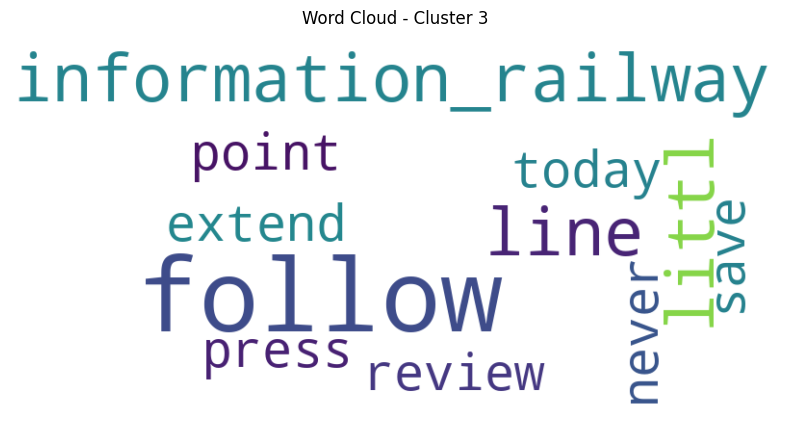

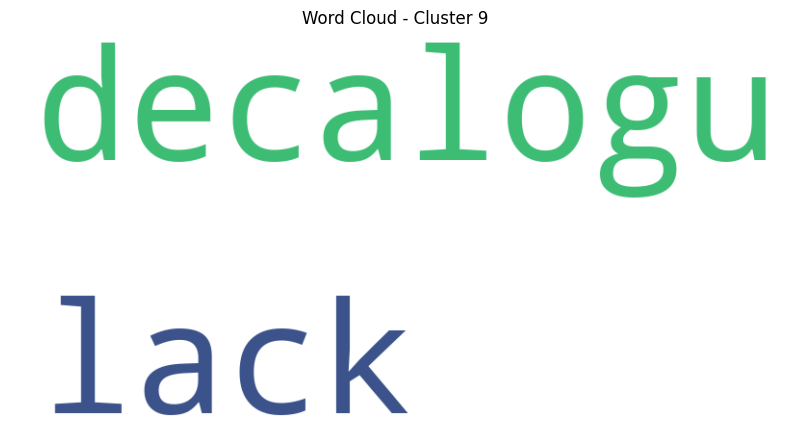

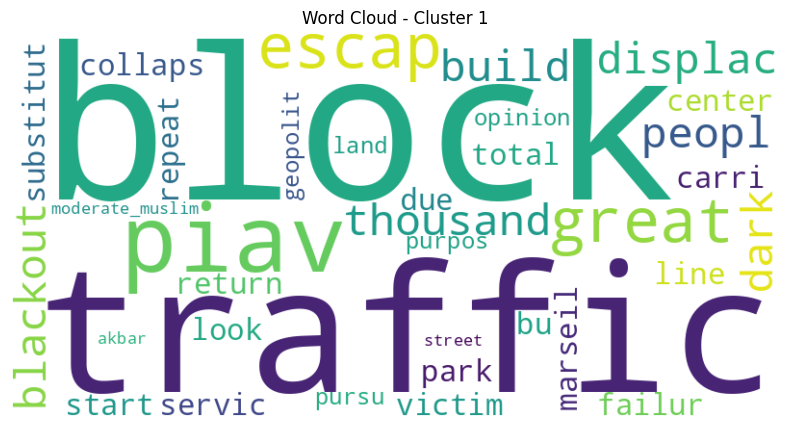

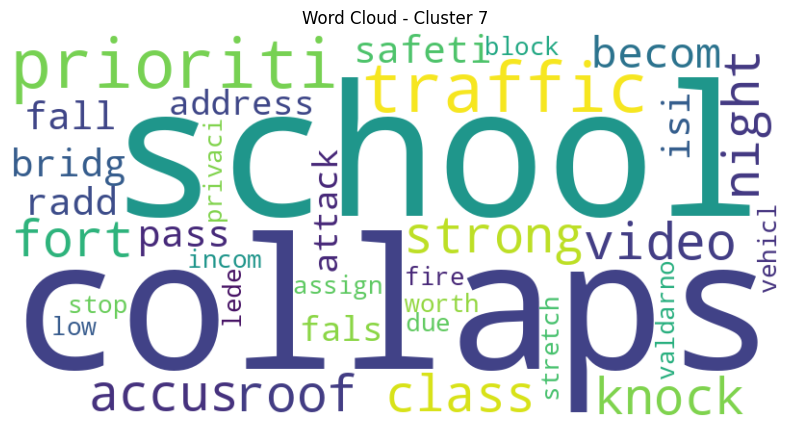

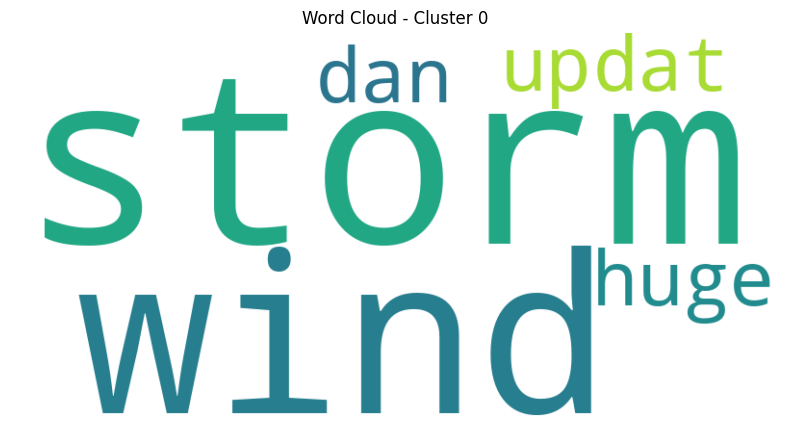

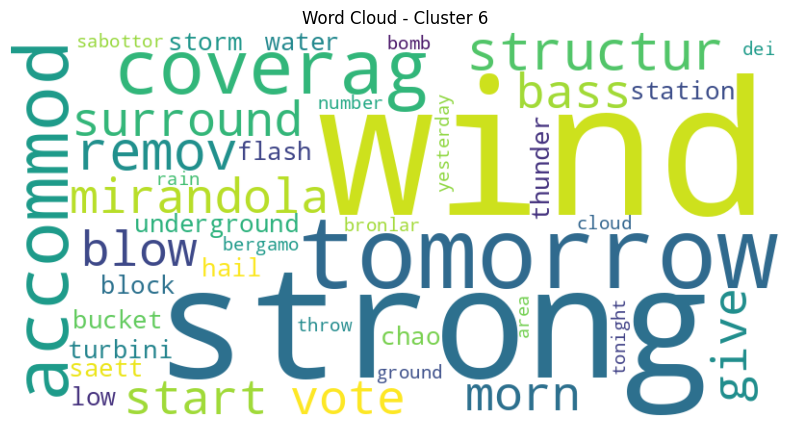

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a 'cluster' column and a 'text' column
# df = ...

# Generate WordClouds for each cluster
for cluster_id in df_new['LDA_topics'].unique():
    # Extract text for the current cluster
    cluster_text = ' '.join(df_new[df_new['LDA_topics'] == cluster_id]['preprocessed'])

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Cluster {cluster_id}')
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to extract keywords from a cluster using TF-IDF
def extract_keywords(cluster_texts):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Find the top keywords for each document (tweet)
    top_keywords = []
    for i in range(len(cluster_texts)):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[-3:][::-1]  # Extract top 3 keywords
        top_keywords.append([feature_names[idx] for idx in top_indices])

    return top_keywords

# Extract keywords for each cluster
cluster_keywords = {}
for cluster_id in df_new['mBERT_LDA_cluster'].unique():
    cluster_texts = df_new[df_new['mBERT_LDA_cluster'] == cluster_id]['preprocessed'].tolist()
    keywords = extract_keywords(cluster_texts)
    cluster_keywords[cluster_id] = keywords

from sklearn.metrics import jaccard_score

def assign_labels(keywords_list):
    event_keywords = {
        'Earthquake': ['earthquake', 'aftershock', 'aftershocks', 'earth vibration', 'quake', 'shoks'],
        'Fire': ['wildfire', 'fire', 'burning', 'blast', 'fir', 'smoke'],
        'Lifeline': ['lifeline', 'emergency', 'casualty', 'fatalities', 'injury', 'death', 'rescue', 'emergency services'],
        'Wind': ['strong wind', 'windstorm', 'gusty winds', 'windy weather', 'air currents', 'breeze', 'wind'],
        'Issues': ['issue', 'problem', 'trouble'],
        'Vandalism': ['vandalism', 'vandal', 'destruction', 'damage', 'graffiti', 'defacement'],
        'Telecommunication': ['internet', 'communication', 'signals', 'network', 'telecom failure', 'internet disruption', 'communication outage', 'network failure', 'signal loss'],
        'Thunderstorm': ['thunderstorm', 'thunder', 'lightning', 'storm', 'heavy rain', 'rainstorm'],
        'Terrorism': ['terrorism', 'terrorist', 'attack', 'bombing', 'explosion', 'hostage', 'extremist', 'militant'],
        'Transport': ['street', 'road', 'arrive', 'travel', 'bus', 'car', 'vehicle', 'railway'],
        'Entertainment': ['concert', 'dance', 'gathering', 'audience'],
        'Eid': ['eid', 'eid ul fitr', 'eid ul adha', 'fitr', 'adha', 'Eid celebrations'],
        'Christmas': ['christmas', 'xmas', 'christ', 'christ day', 'christians day'],
        'Ramadan': ['ramzan', 'ramadan', 'holy month', 'fasting'],
        'Fight': ['fight', 'clash', 'confrontation'],
        'Blast': ['blast', 'explosion', 'bang']
    }

    flat_keywords_list = [keyword for sublist in keywords_list for keyword in sublist]
    label_scores = {label: jaccard_score(set(flat_keywords_list), set(keyword_set), average='weighted') for label, keyword_set in event_keywords.items()}
    cluster_label = max(label_scores, key=label_scores.get)
    return cluster_label

# Ensure consistent lengths
df_new = df_new[df_new['mBERT_LDA_cluster'].notna()]  # Drop rows with NaN cluster
cluster_ids = df_new['mBERT_LDA_cluster'].unique()

# Example usage:
df_new['Event_label'] = df_new['mBERT_LDA_cluster'].apply(lambda cluster_id: assign_labels(cluster_keywords[cluster_id]))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to extract keywords from a cluster using TF-IDF
def extract_keywords(cluster_texts):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Find the top keywords for each document (tweet)
    top_keywords = []
    for i in range(len(cluster_texts)):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[-3:][::-1]  # Extract top 3 keywords
        top_keywords.append([feature_names[idx] for idx in top_indices])

    return top_keywords

# Extract keywords for each cluster
cluster_keywords = {}
for cluster_id in df_new['mBERT_LDA_cluster'].unique():
    cluster_texts = df_new[df_new['mBERT_LDA_cluster'] == cluster_id]['preprocessed'].tolist()
    keywords = extract_keywords(cluster_texts)
    cluster_keywords[cluster_id] = keywords

# Function to assign labels based on keywords
def assign_labels(keywords):
    event_labels = ['Earthquake', 'Fire', 'Lifeline', 'Wimd', 'Issues','Vandalism','Telecommunication', 'Thunderstorm','Terrorism','Transport', 'Entertainment', 'Eid','Christmas','Ramadan','Fight', 'Blast']  # Modify based on your expected events
    label_scores = {label: sum(keyword.lower() in label.lower() for keyword_list in keywords for keyword in keyword_list) for label in event_labels}
    cluster_label = max(label_scores, key=label_scores.get)
    return cluster_label

# Assign labels to clusters based on keywords
df_new['Event_label'] = df_new['mBERT_LDA_cluster'].apply(lambda cluster_id: assign_labels(cluster_keywords[cluster_id]))

# Display the results
print(df_new[['preprocessed', 'mBERT_LDA_cluster', 'Event_label']])

# write the DataFrame to a CSV file
df_new.to_csv('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/24-12-2023/mBERT_LDA_cluster(100).csv')

In [ ]:
df_new=pd.read_csv('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/24-12-2023/mBERT_LDA_cluster(100).csv')

In [ ]:
#remove stopwords, punctuations, lemmatize and tokenize word
# nlp = spacy.load("en_core_web_sm")   #working with english only, no support for swahili
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
#     for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)

df_new['text'] = df_new.tidy_tweet.apply(furnished)

In [ ]:
earthquake = '''earthquake', 'aftershock', 'aftershocks', 'earth vibration', 'quake', 'shoks'''
tsunami = '''tsunami', 'flood', 'flood waves', 'water'''
fire = '''wildfire', 'fire', 'burning', 'blast','fir', 'smoke'''
christmas = '''christmas', 'xmas','christ','christ day', 'christians day'''
eid = '''eid', 'eid ul fitr', 'eid ul adha', 'fitr', 'adha', 'Eid celebrations'''
ramadan = '''ramzan', 'ramadan','holy month', 'fasting'''
independence = '''independence day', 'independence', 'day of independence', 'national day', 'national'''
transportation='''street', 'road', 'arrive', 'travel', 'bus', 'car', 'vehicle', 'railway'''
wind= '''strong wind', 'windstorm', 'gusty winds', 'windy weather', 'air currents', 'breeze', 'wind'''
entertainment='''concert','dance', 'gathering', 'audiance'''
lifeline='''lifeline', 'emergency', 'casualty', 'fatalities', 'injury', 'death', 'rescue', 'emergency services'''
Vandalism='''vandalism', 'vandal', 'destruction', 'damage', 'graffiti', 'defacement'''
TelecomFailure='''internet','communication', 'signals', 'network','telecom failure', 'internet disruption', 'communication outage', 'network failure', 'signal'''
Terrorism='''terrorism', 'terrorist', 'attack', 'bombing', 'explosion', 'hostage', 'extremist', 'terror', 'militant'''
Thunderstorm='''thunderstorm', 'thunder', 'lightning', 'storm', 'heavy rain', 'rainstorm'''

In [ ]:
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()
# clean the set of words
def furnished(text):
    final_text = []
    for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)

In [ ]:
earthquake += furnished(earthquake)
tsunami += furnished(tsunami)
fire += furnished(fire)
Vandalism += furnished(Vandalism)
Terrorism += furnished(Terrorism)
lifeline += furnished(lifeline)
wind += furnished(wind)
christmas += furnished(christmas)
eid += furnished(eid)
ramadan += furnished(ramadan)
independence += furnished(independence)
transportation += furnished(transportation)
entertainment +=  furnished(entertainment)
TelecomFailure +=  furnished(TelecomFailure)
Thunderstorm+=  furnished(Thunderstorm)
e1=earthquake
e2=tsunami
e3=fire
e4=Vandalism
e5=Terrorism
e6=lifeline
e7=wind
e8=christmas
e9=eid
e10=ramadan
e11=independence
e12=transportation
e13=entertainment
e14=TelecomFailure
e15=Thunderstorm

In [ ]:
## Vectorizing the tweets
tv=TfidfVectorizer()
tfidf_tweets =tv.fit_transform(df_new.text)

In [ ]:
string1 = earthquake
words = string1.split()
earthquake = " ".join(sorted(set(words), key=words.index))

In [ ]:
earthquake

"earthquake', 'aftershock', 'aftershocks', 'earth vibration', 'quake', 'shoksearthquake', 'shoks"

In [ ]:
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()
earthquake_vec = get_vectors(earthquake)
tsunami_vec  = get_vectors(tsunami)
fire_vec  = get_vectors(fire)
Vandalism_vec  = get_vectors(Vandalism)
Terrorism_vec  = get_vectors(Terrorism)
lifeline_vec  = get_vectors(lifeline)
wind_vec  = get_vectors(wind)
christmas_vec  = get_vectors(christmas)
eid_vec  = get_vectors(eid)
ramadan_vec  = get_vectors(ramadan)
independence_vec  = get_vectors(independence)
transportation_vec  = get_vectors(transportation)
entertainment_vec  = get_vectors(entertainment)
TelecomFailure_vec  = get_vectors(TelecomFailure)
Thunderstorm_vec = get_vectors(Thunderstorm)
## Vectorizing the tweets
tv=TfidfVectorizer()
tfidf_tweets =tv.fit_transform(df_new.text)

<1x582 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [ ]:
def jaccard_similarity(query, document):
    # Convert NumPy arrays to tuples
    query_tuple = tuple(query)
    document_tuple = tuple(document)

    intersection = set(query_tuple).intersection(set(document_tuple))
    union = set(query_tuple).union(set(document_tuple))

    # Handle the case where the union is empty to avoid division by zero
    if len(union) == 0:
        return 0.0

    return len(intersection) / len(union)


def get_scores(keyword_list, document_list):
    scores = [jaccard_similarity(keyword_list, document) for document in document_list]
    return scores




In [ ]:
q_scores = get_scores(earthquake,  df_new.text.to_list())
w_scores = get_scores(tsunami,  df_new.text.to_list())
e_scores = get_scores(fire,  df_new.text.to_list())
r_scores = get_scores(Vandalism,  df_new.text.to_list())
t_scores = get_scores(Terrorism,  df_new.text.to_list())
y_scores = get_scores(lifeline,  df_new.text.to_list())
u_scores = get_scores(wind,  df_new.text.to_list())
i_scores = get_scores(christmas,  df_new.text.to_list())
o_scores = get_scores(eid,  df_new.text.to_list())
p_scores = get_scores(ramadan,  df_new.text.to_list())
a_scores = get_scores(independence,  df_new.text.to_list())
s_scores = get_scores(transportation,  df_new.text.to_list())
d_scores = get_scores(entertainment,  df_new.text.to_list())
f_scores = get_scores(TelecomFailure,  df_new.text.to_list())
g_scores = get_scores(Thunderstorm,  df_new.text.to_list())
df_new['earthquake_Event_score']=q_scores
df_new['Tsunami_Event_score']=w_scores
df_new['Fire_Event_score']=e_scores
df_new['Vandalism_Event_score']=r_scores
df_new['Terrorism_Event_score']=t_scores
df_new['Lifeline_Event_score']=y_scores
df_new['Wind_Event_score']=u_scores
df_new['Christmas_Event_score']=i_scores
df_new['Eid_Event_score']=o_scores
df_new['Ramadan_Event_score']=p_scores
df_new['Independence_Event_score']=a_scores
df_new['Transportation_Event_score']=s_scores
df_new['Entertainment_Event_score']=d_scores
df_new['TelecomFailure_Event_score']=f_scores
df_new['Thunderstorm_Event_score']=g_scores
def get_clusters(l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14,l15):
    earthquake  = []
    tsunami   = []
    fire  = []
    Vandalism  = []
    Terrorism  = []
    lifeline  = []
    wind  = []
    christmas   = []
    eid   = []
    ramadan  = []
    independence  = []
    transportation  = []
    entertainment  = []
    TelecomFailure  = []
    Thunderstorm  = []
    for i, j, k, o, p, q,r,s,t,u,v,w,x,y,z in zip(l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14,l15):
        m = max(i, j, k, o, p, q,r,s,t,u,v,w,x,y,z)
        if m == i:
            earthquake.append(1)
        else:
            earthquake.append(0)
        if m == j:
            tsunami.append(1)
        else:
            tsunami.append(0)
        if m == k:
            fire.append(1)
        else:
            fire.append(0)
        if m == o:
            Vandalism.append(1)
        else:
            Vandalism.append(0)
        if m == p:
            Terrorism.append(1)
        else:
            Terrorism.append(0)
        if m == q:
            lifeline.append(1)
        else:
            lifeline.append(0)
        if m == r:
            wind.append(1)
        else:
            wind.append(0)
        if m == s:
            christmas.append(1)
        else:
            christmas.append(0)
        if m == t:
            eid.append(1)
        else:
            eid.append(0)
        if m == u:
            ramadan.append(1)
        else:
            ramadan.append(0)
        if m == v:
            independence.append(1)
        else:
            independence.append(0)
        if m == w:
            transportation.append(1)
        else:
            transportation.append(0)
        if m == x:
            entertainment.append(1)
        else:
            entertainment.append(0)
        if m == y:
            TelecomFailure.append(1)
        else:
            TelecomFailure.append(0)
        if m == z:
            Thunderstorm.append(1)
        else:
            Thunderstorm.append(0)
    return earthquake,tsunami,fire,Vandalism,Terrorism,lifeline,wind,christmas,eid,ramadan,independence,transportation,entertainment,TelecomFailure,Thunderstorm
l1 = df_new['earthquake_Event_score'].to_list()
l2 = df_new['Tsunami_Event_score'].to_list()
l3 = df_new['Fire_Event_score'].to_list()
l4 = df_new['Vandalism_Event_score'].to_list()
l5 = df_new['Terrorism_Event_score'].to_list()
l6 = df_new['Lifeline_Event_score'].to_list()
l7 = df_new['Wind_Event_score'].to_list()
l8 = df_new['Christmas_Event_score'].to_list()
l9 = df_new['Eid_Event_score'].to_list()
l10 = df_new['Ramadan_Event_score'].to_list()
l11 = df_new['Independence_Event_score'].to_list()
l12 = df_new['Transportation_Event_score'].to_list()
l13 = df_new['Entertainment_Event_score'].to_list()
l14 = df_new['TelecomFailure_Event_score'].to_list()
l15 = df_new['Thunderstorm_Event_score'].to_list()
earthquake,tsunami,fire,Vandalism,Terrorism,lifeline,wind,christmas,eid,ramadan,independence,transportation,entertainment,TelecomFailure,Thunderstorm = get_clusters(l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14,l15)
df_new['earthquake_Event_Probability']=earthquake
df_new['Tsunami_Event_Probability']=tsunami
df_new['Fire_Event_Probability']=fire
df_new['Vandalism_Probability']=Vandalism
df_new['Terrorism_Probability']=Terrorism
df_new['Lifeline_Probability']=lifeline
df_new['Wind_Event_Probability']=wind
df_new['Christmas_Probability']=christmas
df_new['Eid_Event_Probability']=eid
df_new['Ramadan_Event_Probability']=ramadan
df_new['Independence_Event_Probability']=independence
df_new['Transportation_Event_Probability']=transportation
df_new['Entertainment_Event_Probability']=entertainment
df_new['TelecomFailure_Event_Probability']=TelecomFailure
df_new['Thunderstorm_Event_Probability']=Thunderstorm
df_new.to_csv('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/24-12-2023/mBERT_LDA_cluster_labelled(100).csv')

In [ ]:
    DisasterEvent = ''
    ReligiousEvent = ''
    NationalEvent = ''
    RoadEvents = ''
    OtherEvents = ''
    WeatherEvent= ''
    cluster_label=''
    DisasterEvent += e1
    DisasterEvent += e2
    DisasterEvent += e3
    DisasterEvent += e4
    DisasterEvent += e5
    DisasterEvent += e6
    DisasterEvent += e7
    ReligiousEvent += e8
    ReligiousEvent += e9
    ReligiousEvent += e10
    NationalEvent += e11
    RoadEvents += e12
    OtherEvents +=  e13
    OtherEvents +=  e14
    WeatherEvent+=  e15

In [ ]:
# delete duplicates
string1 = DisasterEvent
words = string1.split()
DisasterEvent = " ".join(sorted(set(words), key=words.index))
DisasterEvent
string1 = ReligiousEvent
words = string1.split()
ReligiousEvent = " ".join(sorted(set(words), key=words.index))
ReligiousEvent
string1 = NationalEvent
words = string1.split()
NationalEvent = " ".join(sorted(set(words), key=words.index))
NationalEvent
string1 = RoadEvents
words = string1.split()
RoadEvents = " ".join(sorted(set(words), key=words.index))
RoadEvents
string1 = OtherEvents
words = string1.split()
OtherEvents = " ".join(sorted(set(words), key=words.index))
OtherEvents
string1 = WeatherEvent
words = string1.split()
WeatherEvent=" ".join(sorted(set(words), key=words.index))
WeatherEvent

"thunderstorm', 'thunder', 'lightning', 'storm', 'heavy rain', 'rainstormthunderstorm', 'rainstorm"

In [ ]:
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()
disaster_vector = get_vectors(DisasterEvent)
religious_vector = get_vectors(ReligiousEvent)
national_vector = get_vectors(NationalEvent)
road_vector = get_vectors(RoadEvents)
other_vector = get_vectors(OtherEvents)
weather_vector = get_vectors(WeatherEvent)

## Vectorizing the tweets
tv=TfidfVectorizer()
tfidf_tweets =tv.fit_transform(df_new.tidy_tweet)

In [ ]:
d_scores = get_scores(DisasterEvent,  df_new.text.to_list())
r_scores = get_scores(ReligiousEvent,  df_new.text.to_list())
n_scores = get_scores(NationalEvent,  df_new.text.to_list())
o_scores = get_scores(OtherEvents,  df_new.text.to_list())
w_scores = get_scores(WeatherEvent,  df_new.text.to_list())
ro_scores = get_scores(RoadEvents,  df_new.text.to_list())

In [ ]:
df_new['Disaster_Event_score']=d_scores
df_new['Religious_Event_score']=r_scores
df_new['National_Event_score']=n_scores
df_new['Other_Event_score']=o_scores
df_new['Weather_Event_score']=w_scores
df_new['Road_Event_score']=ro_scores
def get_clusters(l1, l2, l3, l4, l5, l6):
    disaster = []
    religious = []
    national = []
    road = []
    weather = []
    other = []
    for i, j, k, o, p, q in zip(l1, l2, l3, l4, l5, l6):
        m = max(i, j, k, o, p, q)
        if m == i:
            disaster.append(1)
        else:
            disaster.append(0)
        if m == j:
            religious.append(1)
        else:
            religious.append(0)
        if m == k:
            national.append(1)
        else:
            national.append(0)
        if m == o:
            other.append(1)
        else:
            other.append(0)
        if m == p:
            road.append(1)
        else:
            road.append(0)
        if m == q:
            weather.append(1)
        else:
            weather.append(0)
    return disaster, religious, national, other, road, weather
l1 = df_new.Disaster_Event_score.to_list()
l2 = df_new.Religious_Event_score.to_list()
l3 = df_new.National_Event_score.to_list()
l4 = df_new.Other_Event_score.to_list()
l5 = df_new.Road_Event_score.to_list()
l6 = df_new.Weather_Event_score.to_list()
disaster, religious, national, other, road, weather = get_clusters(l1, l2, l3, l4, l5, l6)
df_new['Disaster_Event_Propability']=disaster
df_new['Religious_Event_Propability']=religious
df_new['National_Event_Propability']=national
df_new['Other_Event_Propability']=other
df_new['Road_Event_Propability']=road
df_new['Weather_Event_Propability']=weather

In [ ]:
df_new

Unnamed: 0.1  Unnamed: 0     TwitterId  \
0              0       51874  1.085690e+18   
1              1       18570  1.050000e+18   
2              2       56790  1.090000e+18   
3              3       34002  1.064210e+18   
4              4        8044  1.024280e+18   
..           ...         ...           ...   
85            89      137537  1.130000e+18   
86            90      119216  1.005040e+18   
87            92      138415  1.100000e+18   
88            95      119702  1.089110e+18   
89            98      138157  1.010000e+18   

                                              Content  \
0   Un nuovo post (In Edicola sul Fatto Quotidiano...   
1   cosa diranno i sapientoni che prevedono tsunam...   
2   RT @RegioneER: #TERREMOTO a #RAVENNA, a fine m...   
3   RT @VaeVictis: Ma che cosÃ¢ÂÂÃÂ¨ che stimol...   
4   RT @SilviettaDreams: Il terremoto distrugge ma...   
..                                                ...   
85  Incidente stradale a Biancavilla, camion si ri...   
86  RT @giopge: Vandali a Villa Pamphili: distrutt...   
87  Grave atto vandalico al Parco di Cavriglia. La...   
88  Viale dei quattro venti numero 37, 00152 ROMA ...   
89  RT @NicolaMorra63: A Roma una sezione del Part...   

                                               Tweets           GPS  \
0   A new post (on newsstands on the daily fact of...  not provided   
1   What the wisentons will say that provide tsuna...  not provided   
2   RT @regioner: #terremoto in #ravenna, at the e...  not provided   
3   RT @vaevictis: but that it is so that it stimu...  not provided   
4   RT @silviettadreams: The earthquake destroys b...  not provided   
..                                                ...           ...   
85  Road accident in Biancavilla, truck overturns ...  not provided   
86  RT @Giopge: Vandals in Villa Pamphili: eight f...  not provided   
87  Serious vandalism at the Cavriglia park. The c...  not provided   
88  Viale dei four twenty number 37, 00152 Rome Mo...  not provided   
89  RT @Nicolamorra63: ??in Rome a section of the ...  not provided   

                Localization          Time                 Classification  \
0                     Italia  1.547680e+12                     Earthquake   
1                    unknown  1.540000e+12                     Earthquake   
2                      Italy  1.550000e+12                     Earthquake   
3   Milano - Verona - Austin  1.542560e+12                     Earthquake   
4          Lombardia, Italia  1.533040e+12                     Earthquake   
..                       ...           ...                            ...   
85                   Palermo  1.560000e+12  Transportation system failure   
86           casa dolce casa  1.528450e+12                      Vandalism   
87           Toscana, Italia  1.550000e+12                      Vandalism   
88                      Roma  1.548500e+12                      Vandalism   
89                   unknown  1.530000e+12                      Vandalism   

                                           tidy_tweet  ...  \
0   a new post  on newsstands on the daily fact of...  ...   
1   what the wisentons will say that provide tsuna...  ...   
2   rt   #terremoto in #ravenna  at the end of the...  ...   
3   rt   but that it is so that it stimulates #lag...  ...   
4   rt   the earthquake destroys but more speculat...  ...   
..                                                ...  ...   
85  road accident in biancavilla  truck overturns ...  ...   
86  rt   vandals in villa pamphili  eight fountain...  ...   
87  serious vandalism at the cavriglia park  the c...  ...   
88  viale dei four twenty number           rome mo...  ...   
89  rt     in rome a section of the democratic par...  ...   

   National_Event_score Other_Event_score Weather_Event_score  \
0              0.538462          0.807692            0.571429   
1              0.535714          0.785714            0.678571   
2              0.523810          0.500000       

In [ ]:
'''new df with names, and the jaccard scores for each group'''

data  = {'Tweet':df.tidy_tweet.to_list(),'Event Names':df.event.to_list(), 'Disaster_Event_score':e_scores,
         'Religious_Event_score': s_scores, 'National_Event_score':c_scores}
scores_df = pd.DataFrame(data)
scores_df.head(20)

Tweet Event Names  \
0   36 aftershock 405 asleep movement bed woke sca...  earthquake   
1   good night friend per usgs new 59 quake mornin...  earthquake   
2    yea wasnt long killed like 6 7 second sure would  earthquake   
3   honored essay aftershock marking 50th annivers...  earthquake   
4         ticket sale aftershock nowplaying k4hdradio  earthquake   
5                                   come u aftershock  earthquake   
6                            oo think felt aftershock  earthquake   
7   quick comparison ongoing 2020 m64 puerto rico ...  earthquake   
8   puerto ricans refusing go home aside 54 afters...  earthquake   
9   2010 inception social network easy black swan ...  earthquake   
10  puerto rico hit another 59 magnitude aftershoc...  earthquake   
11  puerto rico hit another 59 magnitude aftershoc...  earthquake   
12                                           hard hit  earthquake   
13  musharaf verdict mild aftershock extension one...  earthquake   
14  puerto rico hit another 59 magnitude aftershoc...  earthquake   
15  kumera yellow aftershock ph19fossil featured b...  earthquake   
16  puerto rico hit another 59 magnitude aftershoc...  earthquake   
17                             please pray puertorico  earthquake   
18  puerto rico hit another 59 magnitude aftershoc...  earthquake   
19                                             yakovz  earthquake   

    Disaster_Event_score  Religious_Event_score  National_Event_score  
0               0.612903               0.531250              0.428571  
1               0.655172               0.566667              0.407407  
2               0.592593               0.555556              0.500000  
3               0.678571               0.642857              0.480000  
4               0.629630               0.592593              0.545455  
5               0.541667               0.500000              0.285714  
6               0.583333               0.541667              0.473684  
7               0.580645               0.500000              0.344828  
8               0.666667               0.571429              0.400000  
9               0.600000               0.566667              0.461538  
10              0.607143               0.629630              0.458333  
11              0.607143               0.629630              0.458333  
12              0.291667               0.304348              0.312500  
13              0.730769               0.692308              0.458333  
14              0.607143               0.629630              0.458333  
15              0.724138               0.689655              0.428571  
16              0.607143               0.629630              0.458333  
17              0.423077               0.500000              0.588235  
18              0.607143               0.629630              0.458333  
19              0.153846               0.160000              0.176471

In [ ]:
data  = {'Tweet':df.text.to_list(),'Event Names':df.event.to_list(), 'Disaster_Event_score':disaster,
         'Religious_Event_score': religious, 'National_Event_score':national}
scores_df = pd.DataFrame(data)
scores_df.head(5)

Tweet Event Names  \
0  36 aftershock 405 asleep movement bed woke sca...  earthquake   
1  good night friend per usgs new 59 quake mornin...  earthquake   
2   yea wasnt long killed like 6 7 second sure would  earthquake   
3  honored essay aftershock marking 50th annivers...  earthquake   
4        ticket sale aftershock nowplaying k4hdradio  earthquake   

   Disaster_Event_score  Religious_Event_score  National_Event_score  
0                     1                      0                     0  
1                     1                      0                     0  
2                     1                      0                     0  
3                     1                      0                     0  
4                     1                      0                     0

In [ ]:
'''Due to the close similarity between the tweets, some tweets have multiple categories, so to take care of that the rows with a sum > 1 will have to share the categories. After this, clustering will take care
of the fractions'''

a =  df_LDA[['Disaster_Event_score', 'Religious_Event_score', 'National_Event_score', 'Other_Event_Propability', 'Road_Event_Propability', 'Weather_Event_Propability']].sum(axis = 1) > 1
c = df_LDA[['Disaster_Event_score', 'Religious_Event_score', 'National_Event_score', 'Other_Event_Propability', 'Road_Event_Propability', 'Weather_Event_Propability']].sum(axis = 1)
# b = cluster_df.copy()
df_LDA.loc[(a), ['Disaster_Event_score', 'Religious_Event_score', 'National_Event_score', 'Other_Event_Propability', 'Road_Event_Propability', 'Weather_Event_Propability']] = 1/c

In [ ]:
df_LDA.shape

(10000, 30)

In [ ]:
df_LDA.to_csv(('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/22-12-2023/LDA_cluster_Labelled_Data(1000).csv'))

In [ ]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039284 sha256=c526a9b08674f0631a95c813961610c97572536c6bcf7583427d7c6130164dd0
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.6
    Uninstalling Cython-3.0.6:
      Successfully uninstalled Cython-3.0.6


In [ ]:
import pandas as pd
df_new=df
from datetime import datetime
# Assuming df_new['Time'] is a column in your DataFrame
df_new['Formatted_Time'] = df_new['Time'].apply(lambda x: datetime.utcfromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
# Print or display the resulting DataFrame
# Assuming df is your DataFrame with a 'time' column
# Convert 'time' column to datetime format
df_new['Formatted_Time'] = pd.to_datetime(df_new['Formatted_Time'])

# Extract month, day, and hour from the 'time' column
df_new['month'] = df_new['Formatted_Time'].dt.month
df_new['day'] = df_new['Formatted_Time'].dt.day
df_new['hour'] = df_new['Formatted_Time'].dt.hour

# Define time slots (adjust as needed)
time_slots = [(0, 3), (4, 7), (8, 11), (12, 15), (16, 19), (20, 23)]

# Function to assign slots based on the hour
def assign_time_slot(hour):
    for slot, (start, end) in enumerate(time_slots, start=1):
        if start <= hour <= end:
            return slot
    return None

# Apply the function to create a 'time_slot' column
df_new['time_slot'] = df_new['hour'].apply(assign_time_slot)

# Display the resulting DataFrame
print(df_new[['Tweets','Time', 'month', 'day', 'hour', 'time_slot', 'Localization','extracted_hashtags','Classification']])


                                                   Tweets          Time  \
0       Rt 24Edilizia earthquake, the senatostampa lau...  1.530270e+12   
1                RT @Monycamarini: Dateme na hand, power:  1.530270e+12   
2       RT @quirinale: the day of the president #Matta...  1.530270e+12   
3       Central Italy Earthquake: Flowering of Castell...  1.530270e+12   
4       Laquila earthquake: amendment rejected, dalfon...  1.530270e+12   
...                                                   ...           ...   
273318  April 25: From the north to the south of Unesc...  1.560000e+12   
273319  Vandalic raids at the Terme di Sciacca reporte...  1.560000e+12   
273320  Vandals and damage to the Terme di Sciacca, 13...  1.560000e+12   
273321  Vandalic raids at the Terme di Sciacca, 13 you...  1.560000e+12   
273322  Vandalic raids at the Terme di Sciacca, 13 you...  1.560000e+12   

        month  day  hour  time_slot      Localization  \
0           6   29    11          3       

In [ ]:
periodic_data=df_new[['Tweets','Time', 'month', 'day', 'hour', 'time_slot', 'Localization','extracted_hashtags','Classification']]

In [ ]:
periodic_data.to_csv(('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/22-12-2023/Periodic_Labelled_Data(total).csv'))

In [ ]:
periodic_data=pd.read_csv(('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/22-12-2023/Periodic_Labelled_Data(total).csv'))

<ipython-input-6-49c8c5bdd3c8>:1: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  periodic_data=pd.read_csv(('gdrive/My Drive/Colab Notebooks/Preprocessed Datasets/new/22-12-2023/Periodic_Labelled_Data(total).csv'))


In [ ]:
periodic_data

Unnamed: 0                                             Tweets  \
0               0  Rt 24Edilizia earthquake, the senatostampa lau...   
1               1           RT @Monycamarini: Dateme na hand, power:   
2               2  RT @quirinale: the day of the president #Matta...   
3               3  Central Italy Earthquake: Flowering of Castell...   
4               4  Laquila earthquake: amendment rejected, dalfon...   
...           ...                                                ...   
307283     273318  April 25: From the north to the south of Unesc...   
307284     273319  Vandalic raids at the Terme di Sciacca reporte...   
307285     273320  Vandals and damage to the Terme di Sciacca, 13...   
307286     273321  Vandalic raids at the Terme di Sciacca, 13 you...   
307287     273322  Vandalic raids at the Terme di Sciacca, 13 you...   

                Time  month   day  hour time_slot      Localization  \
0       1.530270e+12    6.0  29.0  11.0       3.0             Italy   
1       1.530270e+12    6.0  29.0  11.0       3.0           unknown   
2       1.530270e+12    6.0  29.0  11.0       3.0            Milano   
3       1.530270e+12    6.0  29.0  11.0       3.0            Italia   
4       1.530270e+12    6.0  29.0  11.0       3.0           unknown   
...              ...    ...   ...   ...       ...               ...   
307283  1.560000e+12    6.0   8.0  13.0         4  Catania, Sicilia   
307284  1.560000e+12    6.0   8.0  13.0         4           Palermo   
307285  1.560000e+12    6.0   8.0  13.0         4           Palermo   
307286  1.560000e+12    6.0   8.0  13.0         4            Ragusa   
307287  1.560000e+12    6.0   8.0  13.0         4           Palermo   

                                       extracted_hashtags Classification  
0                                                     NaN     Earthquake  
1                                                     NaN     Earthquake  
2       #mattarella #esanatoglia #mattarella #esanatoglia     Earthquake  
3                 #terremoto #centerã #terremoto #centerã     Earthquake  
4                                                     NaN     Earthquake  
...                                                   ...            ...  
307283                                  #thexeon #thexeon      Vandalism  
307284                                                NaN      Vandalism  
307285                                                NaN      Vandalism  
307286                                                NaN      Vandalism  
307287                                                NaN      Vandalism  

[307288 rows x 10 columns]

In [ ]:
pip install hdbscan

In [ ]:
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

# Assuming df_new['extract_keywords'] contains preprocessed text data
vectorizer = TfidfVectorizer(stop_words='english')

# Replace NaN values with an empty string
periodic_data['Classification'].fillna('', inplace=True)

# Filter out rows with empty or stop word-only documents
non_empty_rows = periodic_data['Classification'].apply(lambda x: len(x.split()) > 0)
numeric_data = periodic_data[non_empty_rows]

# Check if there are any valid documents after filtering
if numeric_data.empty:
    print("No valid documents after filtering.")
    exit()

# Concatenate 'Event_Class' and 'Localization' before applying the vectorizer
keywords_matrix = vectorizer.fit_transform(numeric_data['Classification'])

# Check if vocabulary is not empty
if keywords_matrix.shape[1] == 0:
    print("Vocabulary is empty. Check your documents or adjust stop words.")
    exit()

# Extract other relevant features
other_features = numeric_data[['day', 'month', 'time_slot']]

# Combine TF-IDF features and other features
X = StandardScaler().fit_transform(keywords_matrix.toarray())
X = np.concatenate((X, other_features.values), axis=1)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
numeric_data['Classification'] = clusterer.fit_predict(X)

# Visualize the clusters in 2D using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for visualization
df_visualize = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'Cluster_Labels': numeric_data['Classification']})

# Map negative cluster labels to NaN
df_visualize['Cluster_Labels'] = df_visualize['Cluster_Labels'].apply(lambda x: x if x >= 0 else np.nan)

# Create a condensed distance matrix
condensed_distance_matrix = sch.linkage(X_pca, method='ward')

# Plot the cluster dendrogram
plt.figure(figsize=(15, 8))
dendrogram = sch.dendrogram(condensed_distance_matrix, truncate_mode='level', p=10, labels=df_visualize['Cluster_Labels'].to_numpy())
plt.title('HDBSCAN Clustering Dendrogram')
plt.show()


NameError: ignored

In [ ]:
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

# Assuming df_new['extract_keywords'] contains preprocessed text data
vectorizer = TfidfVectorizer(stop_words='english')

# Replace NaN values with an empty string
periodic_data['Classification'].fillna('', inplace=True)
#periodic_data['Localization'].fillna('', inplace=True)

# Concatenate 'Event_Class' and 'Localization' before applying the vectorizer
keywords_matrix = vectorizer.fit_transform(periodic_data['Classification'])

# Extract other relevant features
other_features = periodic_data[['day', 'month', 'time_slot']]

# Combine TF-IDF features and other features
X = StandardScaler().fit_transform(keywords_matrix.toarray())
X = np.concatenate((X, other_features.values), axis=1)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
periodic_data['Classification'] = clusterer.fit_predict(X)

# Visualize the clusters in 2D using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for visualization
df_visualize = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'Cluster_Labels': periodic_data['Classification']})

# Map negative cluster labels to NaN
df_visualize['Cluster_Labels'] = df_visualize['Cluster_Labels'].apply(lambda x: x if x >= 0 else np.nan)

# Create a condensed distance matrix
condensed_distance_matrix = sch.linkage(X_pca, method='ward')

# Plot the cluster dendrogram
plt.figure(figsize=(15, 8))
dendrogram = sch.dendrogram(condensed_distance_matrix, truncate_mode='level', p=10, labels=df_visualize['Cluster_Labels'].to_numpy())
plt.title('HDBSCAN Clustering Dendrogram')
plt.show()


ValueError: ignored

<ipython-input-139-2ed669aa27d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  periodic_data['Classification'].fillna('', inplace=True)
<ipython-input-139-2ed669aa27d7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  periodic_data['Localization'].fillna('', inplace=True)
<ipython-input-139-2ed669aa27d7>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  periodic_data['Classi

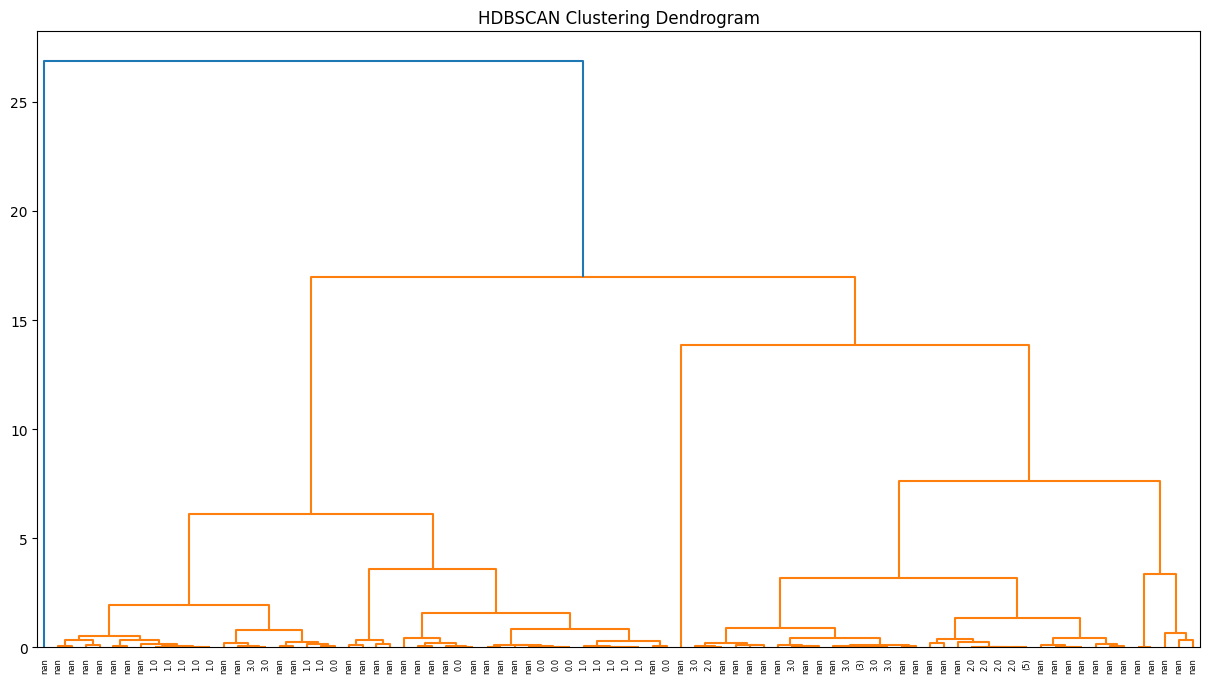

In [ ]:
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

# Assuming df_new['extract_keywords'] contains preprocessed text data
vectorizer = TfidfVectorizer(stop_words='english')

# Replace NaN values with an empty string
periodic_data['Classification'].fillna('', inplace=True)
periodic_data['Localization'].fillna('', inplace=True)

# Convert 'Classification' and 'Localization' columns to strings and then concatenate
concatenated_text = periodic_data['Classification'].astype(str) + ' ' + periodic_data['Localization'].astype(str)

# Apply TF-IDF vectorization
keywords_matrix = vectorizer.fit_transform(concatenated_text)

# Extract other relevant features
other_features = periodic_data[['day', 'hour', 'time_slot']]

# Combine TF-IDF features and other features
X_tfidf = keywords_matrix.toarray()
X_other = other_features.values.astype(np.float64)
X = StandardScaler().fit_transform(np.concatenate((X_tfidf, X_other), axis=1))

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
periodic_data['Classification'] = clusterer.fit_predict(X)

# Visualize the clusters in 2D using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for visualization
df_visualize = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'Cluster_Labels': periodic_data['Classification']})

# Map negative cluster labels to NaN
df_visualize['Cluster_Labels'] = df_visualize['Cluster_Labels'].apply(lambda x: x if x >= 0 else np.nan)

# Create a condensed distance matrix
condensed_distance_matrix = sch.linkage(X_pca, method='ward')

# Plot the cluster dendrogram
plt.figure(figsize=(15, 8))
dendrogram = sch.dendrogram(condensed_distance_matrix, truncate_mode='level', p=10, labels=df_visualize['Cluster_Labels'].to_numpy())
plt.title('HDBSCAN Clustering Dendrogram')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_new['ground_truth_labels'] contains the ground truth labels
# Replace 'ground_truth_labels' with the actual column name if it's different
ground_truth_labels = df_new['Classification'].astype(str)

# Assuming df_new['extract_keywords'] contains preprocessed text data
vectorizer = TfidfVectorizer(stop_words='english')

# Replace NaN values with an empty string
df_new['Localization'].fillna('', inplace=True)

# Concatenate 'extract_keywords' and 'ground_truth_labels' before applying the vectorizer
concatenated_text = df_new['Localization'] + ' ' + ground_truth_labels

# Apply TF-IDF vectorization
keywords_matrix = vectorizer.fit_transform(concatenated_text)

# Extract other relevant features
other_features = df_new[['day', 'hour', 'time_slot']]

# Combine TF-IDF features and other features
X_tfidf = keywords_matrix.toarray()
X_other = other_features.values.astype(np.float64)
X = StandardScaler().fit_transform(np.concatenate((X_tfidf, X_other), axis=1))

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
df_new['predicted_clusters'] = clusterer.fit_predict(X)

# Visualize the comparison between predicted clusters and ground truth labels
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='predicted_clusters', style=ground_truth_labels, data=df_visualize, palette='viridis', legend='full')
plt.title('Comparison: Predicted Clusters vs. Ground Truth Labels')
plt.show()


In [ ]:
pip install plotly

In [ ]:
pivot_clusters = scores_df.groupby(['']).sum()
pivot_clusters['Disaster_Event_score'] = pivot_clusters['Disaster_Event_score'].astype(int)
pivot_clusters['Religious_Event_score'] = pivot_clusters['Religious_Event_score'].astype(int)
pivot_clusters['National_Event_score'] = pivot_clusters['National_Event_score'].astype(int)
pivot_clusters['total'] = pivot_clusters['National_Event_score'] + pivot_clusters['Religious_Event_score'] +  pivot_clusters['Disaster_Event_score']
pivot_clusters.loc["Total"] = pivot_clusters.sum()  #add a totals row
print(pivot_clusters.shape)
pivot_clusters.tail()

(15, 4)


Disaster_Event_score  Religious_Event_score  \
Event Names                                                 
thunderstorm                    78                     14   
tornedo                         21                      8   
tsunami                         54                     31   
wildfire                        72                     23   
Total                          639                    400   

              National_Event_score  total  
Event Names                                
thunderstorm                     0     92  
tornedo                          3     32  
tsunami                         14     99  
wildfire                         3     98  
Total                           58   1097

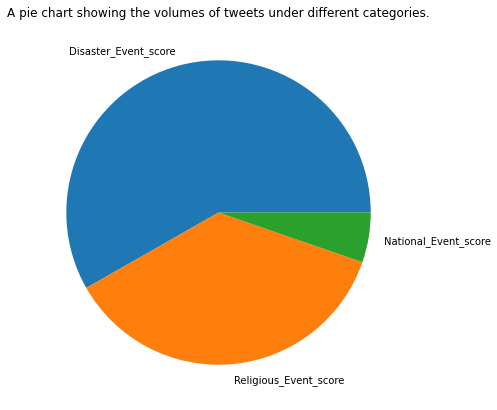

In [ ]:
'''A pie chart to show the total number of tweets in each category'''

fig = plt.figure(figsize =(10, 7))
a = pivot_clusters.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()

In [ ]:
# Normal Distribution Function

from statistics import mean
import re
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
pivot_clusters.drop(pivot_clusters.tail(1).index,inplace=True)

F:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 45.64 and sigma = 20.21



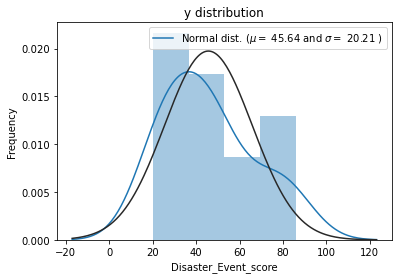

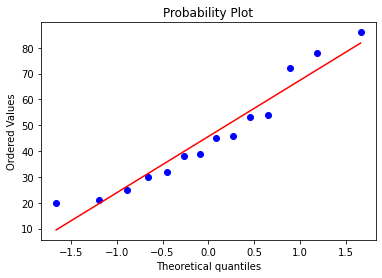

In [ ]:
# Target variable
sns.distplot(pivot_clusters.Disaster_Event_score , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.Disaster_Event_score)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.title('Ecocnomy tweets distribution plot')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.Disaster_Event_score, plot=plt)
plt.show()